In [96]:
import numpy as np
import math

In [97]:
G = 10E9

carrier_frequency = 2 * G

g1, g2, g3, g4 = 32.4, 14, 15, 0.5 

w = 20

n_users_floor = 20

height_floors = 5

coordinates_uav = [0, 0, 0]

users_positions_xy = np.full((10, 3), fill_value=[1,1,1])
users_positions_xz = np.full((10, 3), fill_value=[1,1,1])

In [98]:
x_coordinates = np.arange(10)
y_coordinates = np.arange(10)
z_coordinates = np.arange(10)

np.random.shuffle(x_coordinates)
np.random.shuffle(y_coordinates)
np.random.shuffle(z_coordinates)

acc, count = 1, 0
for i in range(len(users_positions_xy)):
    count += 1

    users_positions_xy[i][0] = x_coordinates[i]
    users_positions_xy[i][2] = acc 
    users_positions_xy[i][1] = y_coordinates[i]
    if count == 2:
        acc += 1
        count = 0
acc, count = 1, 0 
for i in range(len(users_positions_xz)):
    count += 1

    users_positions_xz[i][0] = x_coordinates[i]
    users_positions_xz[i][2] = y_coordinates[i]
    users_positions_xz[i][1] = acc
    if count == 2:
        acc += 1 
        count = 0

In [99]:
users_positions_xy

array([[1, 0, 1],
       [8, 2, 1],
       [0, 9, 2],
       [9, 7, 2],
       [4, 4, 3],
       [5, 6, 3],
       [7, 1, 4],
       [6, 5, 4],
       [3, 8, 5],
       [2, 3, 5]])

We can see how the users are spreaded throughout the building by plotting
each user as a dot on a plane.

Text(0.5, 0, 'Z')

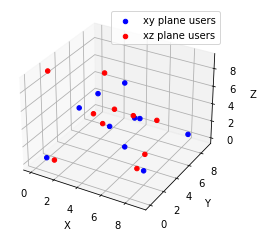

In [100]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

[x_plot_xy, y_plot_xy, z_plot_xy] = users_positions_xy.T
[x_plot_xz, y_plot_xz, z_plot_xz] = users_positions_xz.T

ax.scatter(x_plot_xy, y_plot_xy, z_plot_xy, alpha=1, color='blue', label='xy plane users')
ax.scatter(x_plot_xz, y_plot_xz, z_plot_xz, alpha=1, color='red', label='xz plane users')

ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


The theorems showed in the paper tell us that the best coordinates y and z for the uav
are equal to half of they magnitude. Now, there's only one coordinate remaining until
we can find the best position of our uav: the x coordinate

In [101]:
coordinates_uav[0] = 10 / 2
coordinates_uav[1] = 10 / 2

In [102]:
distance_drone_users_xy = []
distance_drone_users_xz = []
for i in range(len(users_positions_xy)):
    distance_drone_user = np.linalg.norm(users_positions_xy[i] - coordinates_uav)
    distance_drone_users_xy.append(distance_drone_user)

In [103]:
print(distance_drone_users_xy)

[6.48074069840786, 4.358898943540674, 6.708203932499369, 4.898979485566356, 3.3166247903554, 3.1622776601683795, 6.0, 4.123105625617661, 6.164414002968976, 6.164414002968976]


In [104]:
angle_users_xy = []
angle_users_xz = []
for i in range(len(users_positions_xy)):
    angle_user_xy = np.arccos( ( ((coordinates_uav[0] - users_positions_xy[i][0]) ** 2 + (coordinates_uav[1] - users_positions_xy[i][1]) ** 2) ** 0.5 )/distance_drone_users_xy[i])
    angle_users_xy.append(angle_user_xy)

In [105]:
angle_users_xy

[0.15492231987081392,
 0.23147736397017918,
 0.30274595162300466,
 0.4205343352839647,
 1.1302856637901981,
 1.2490457723982544,
 0.7297276562269663,
 1.3258176636680326,
 0.9460424580298534,
 0.9460424580298534]

Defines the Loss function to be optimized in order to minimize the transmit power


In [106]:
def loss(coordinates_uav, w, distance_drone_users, users_coordinates , angle_users, g1, g2, g3, g4, frequency):
    loss = 0
    for i in range(len(distance_drone_users)):
        k = w * math.log10(frequency) + g1 + g2 + g4 * np.linalg.norm(users_coordinates[i][0:2] - 
        coordinates_uav[0:2])
        loss += w * np.log10(distance_drone_users[i]) + g3 * (1 - np.cos(angle_users[i]) ** 2) + k 
    return loss

Plot the loss function for the problem


In [107]:

def gradient(uav_coordinates, distance_drone_users, users_coordinates, w, g3):
    gradient_value = 0
    for i in range(len(users_coordinates)):
        gradient_value += - w * (users_coordinates[i][0] - uav_coordinates[0]) / (np.log(10) 
        * distance_drone_users[i] ** 2) + 2 * g3 * (1 - np.linalg.norm(
            users_coordinates[i][0:2] - uav_coordinates[0:2]) / distance_drone_users[i]) * ( 
                ( (users_coordinates[i][0] - uav_coordinates[0]) * distance_drone_users[i] * (
                    (users_coordinates[i][0] - uav_coordinates[0]) ** 2 + (users_coordinates[i][1] - 
                    uav_coordinates[1]) ** 2 ) ** - 0.5) / (distance_drone_users[i]) ** 2) - ( (np.linalg.norm(
                        users_coordinates[i][0:2] - uav_coordinates[0:2]) * (users_coordinates[i][0] - 
                        uav_coordinates[0]) * distance_drone_users[i] ** -1) / distance_drone_users[i] ** 2 )
    return gradient_value
    

In [160]:
x_uav_n, x_uav = 0, 0
max_iterations = 500
step_size = 0.01

tolerance = 0.001
i = 0
steps = []
while i < max_iterations:
    coordinates_uav[0] = x_uav_n
    x_uav = x_uav_n
    gradient_value = gradient(coordinates_uav, distance_drone_users_xy, users_positions_xy, w, g3)
    x_uav_n = x_uav - step_size * gradient_value

    steps.append(x_uav_n)
    if np.abs(x_uav_n - x_uav) < tolerance:
        break 
    i += 1 
#print(steps, file=open('gradient.txt', 'w'))

In [161]:
print("optimum value: " + str(x_uav_n) + "m")

optimum value: 5.00623580603325


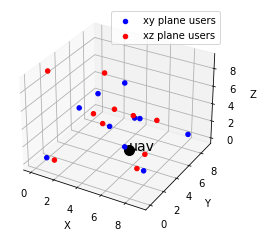

In [110]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

[x_plot_xy, y_plot_xy, z_plot_xy] = users_positions_xy.T
[x_plot_xz, y_plot_xz, z_plot_xz] = users_positions_xz.T

ax.scatter(x_plot_xy, y_plot_xy, z_plot_xy, alpha=1, color='blue', label='xy plane users')
ax.scatter(x_plot_xz, y_plot_xz, z_plot_xz, alpha=1, color='red', label='xz plane users')
ax.scatter(coordinates_uav[0], coordinates_uav[1], coordinates_uav[2], alpha=1, color='black', s=100)
ax.text(coordinates_uav[0], coordinates_uav[1], coordinates_uav[2], "uav", color='black', fontsize=14)
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
fig.savefig('graphs/graph_uav.jpg')


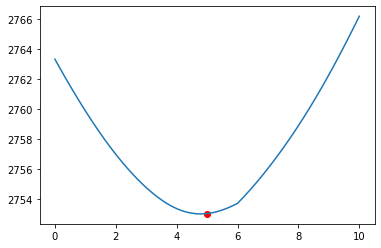

In [162]:
import matplotlib.animation as manimation

n = 500

x = np.linspace(0, 10, num=n)

coordinates_uav_test = list(map(lambda x: [x, 5, 5], x))
steps_loss = list(map(lambda step: loss([step, 5, 5], w, distance_drone_users_xy,
    users_positions_xy,angle_users_xy, g1, g2, g3, g4, carrier_frequency), steps))
y = []
for coordinate in coordinates_uav_test:
    y.append(loss(coordinate, w, distance_drone_users_xy,users_positions_xy,angle_users_xy, g1, g2, g3, g4, carrier_frequency))

fig = plt.figure()
loss_function_graph,  = plt.plot(x, y)
gradient_steps_plot,  = plt.plot([], [], 'ro', markersize='10')
text_plot = plt.text(0, 0, '')
optimal_point = plt.scatter(coordinates_uav[0], loss(coordinates_uav, w, distance_drone_users_xy,users_positions_xy,angle_users_xy, g1, g2, g3, g4, carrier_frequency)
    , color='red')

# plt.axhline(y=min(y), color='r', linestyle='-')

#plt.savefig('graphs/gradient_descent.jpg')

In [164]:
# Define the meta data for the movie
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='a red circle following a blue sine wave')
writer = FFMpegWriter(fps=15, metadata=metadata)

# Update the frames for the movie
with writer.saving(fig, "animacao_lamartine.mp4", 100):
    for i in range(len(steps)):
        x0 = steps[i]
        y0 = steps_loss[i]
        text_plot.set_x(x0)
        text_plot.set_y(y0)
        text_plot.set_text('y value: {y0}'.format(y0=y0))
        gradient_steps_plot.set_data(x0, y0)
        writer.grab_frame()